In [5]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import pickle
import keras
from keras.models import load_model

sns.set(font_scale=0.6)

### Loading the Data

In [11]:
# load data into df
path = 'data/Dataset-PT.csv'
df = pd.read_csv(path, header=1)

# recreare training and testing data, in case it might be useful later
df['upstream_delay_incl_dwell'] = df['upstream_stop_delay'] + df['dwell_time']
df['dwell_incl_origin'] = np.abs(df['previous_bus_delay'] - df['origin_delay'])
X = df[['scheduled_travel_time','previous_bus_delay','previous_trip_travel_time',
'recurrent_delay', 'upstream_delay_incl_dwell']]
y = df['arrival_delay']
# fit scaler only on training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Loading the pre-trained models

In [6]:
# Linear regression
with open('models/linear_regression.pkl', 'rb') as f:
    model_lr = pickle.load(f)

# Decision tree
with open('models/decision_tree.pkl', 'rb') as f:
    model_dt = pickle.load(f)

# XGBoost
model_xgb = xgb.XGBRegressor()
model_xgb.load_model('models/xgboost.json')

# Neural Net
model_nn = keras.models.load_model('models/neural_net.keras')

In [7]:
models = [model_lr, model_dt, model_xgb, model_nn]
model_names = ['linear_regression', 'decision_tree', 'XGBoost', 'Neural_Net']

### Creating Dataset for different scenarios

In [8]:
# dataset for outliers
df_outliers_low = df[df['arrival_delay'] < -400]
df_outliers_high = df[df['arrival_delay'] > 1000]

# datasets for weather conditions
df_weather_light_rain = df[df['weather'] == 'Light Rain']
df_weather_light_snow = df[df['weather'] == 'Light Snow']
df_weather_normal = df[df['weather'] == 'Normal']
df_weather_rain = df[df['weather'] == 'Rain']
df_weather_snow = df[df['weather'] == 'Snow']

# datasets for day of week
df_weekday = df[df['day_of_week'] == 'weekday']
df_weekend = df[df['day_of_week'] == 'weekend']

# datasets for time of day
df_afternoon = df[df['time_of_day'] == 'AP']
df_morning = df[df['time_of_day'] == 'MP']
df_offpeak = df[df['time_of_day'] == 'OP']

df_array = [df, df_outliers_low, df_outliers_high, df_weather_light_rain, df_weather_light_snow, df_weather_normal,
           df_weather_rain, df_weather_snow, df_weekday, df_weekend, df_afternoon, df_morning, df_offpeak]

df_array_names = [
    'df', 'df_outliers_low', 'df_outliers_high', 'df_weather_light_rain', 'df_weather_light_snow', 'df_weather_normal',
    'df_weather_rain', 'df_weather_snow', 'df_weekday', 'df_weekend', 'df_afternoon', 'df_morning', 'df_offpeak'
]

Length of all sub-df, sorted:
df  -  545103
df_outliers_low  -  361
df_outliers_high  -  1695
df_weather_light_rain  -  13338
df_weather_light_snow  -  9720
df_weather_normal  -  514971
df_weather_rain  -  3375
df_weather_snow  -  3699
df_weekday  -  418149
df_weekend  -  126954
df_afternoon  -  113751
df_morning  -  89883
df_offpeak  -  341469


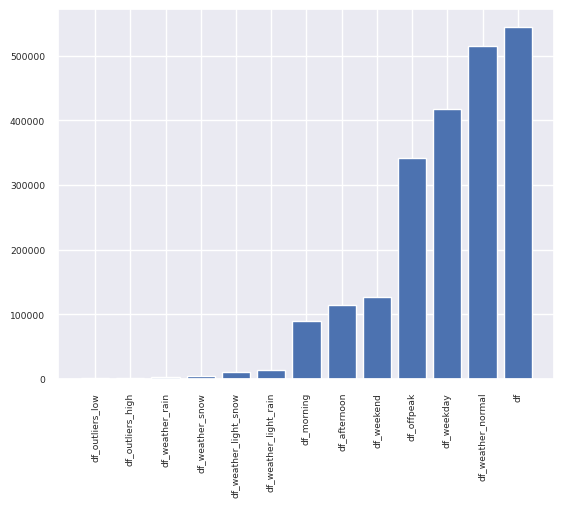

In [18]:
print('Length of all sub-df, sorted:')
lengths = [(df_array_names[i], len(df_subset)) for i, df_subset in enumerate(df_array)]
[print(i[0], ' - ', i[1]) for i in lengths]

lengths = sorted(lengths, key=lambda x: x[1])

plt.bar([i[0] for i in lengths], [i[1] for i in lengths])
plt.xticks(rotation=90)
plt.show()

### Computing evalutation metrics for the different datasets

In [12]:
result_df = pd.DataFrame(columns=['input_data', 'model', 'MAE', 'MSE', 'RMSE', 'R2'])

# iterate through models and subsets
for i, model in enumerate(models):
    for j, df_subset in enumerate(df_array):

        # split into input data and observations, and scale like the model training data
        y_outliers = df_subset['arrival_delay']
        X_outliers = scaler.transform(df_subset[['scheduled_travel_time','previous_bus_delay','previous_trip_travel_time',
        'recurrent_delay', 'upstream_delay_incl_dwell']])

        # compute evaluation metric and
        y_pred = model.predict(X_outliers)
        mae = mean_absolute_error(y_outliers, y_pred)
        mse = mean_squared_error(y_outliers, y_pred)
        r2 = r2_score(y_outliers, y_pred)

        result_df.loc[len(result_df)] = [
            df_array_names[j],
            model_names[i],
            mae,
            mse,
            np.sqrt(mse),
            r2
        ]

result_df.sort_values(by='R2')

17035/17035 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16093/16093 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13068/13068 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
3968/3968 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3555/3555 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
2809/2809 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
10671/10671 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


,input_data,model,MAE,MSE,RMSE,R2
27,df_outliers_low,XGBoost,649.644882,968538.538135,984.143556,-0.747706
28,df_outliers_high,XGBoost,144.815792,56738.963103,238.199419,0.028952
14,df_outliers_low,decision_tree,172.547021,236528.413964,486.341869,0.573190
37,df_morning,XGBoost,16.350863,3873.419695,62.236803,0.876962
15,df_outliers_high,decision_tree,38.381793,5531.409619,74.373447,0.905334
41,df_outliers_high,Neural_Net,30.691785,4460.162546,66.784448,0.923667
2,df_outliers_high,linear_regression,27.738943,4249.558117,65.188635,0.927272
34,df_weekday,XGBoost,15.227711,1519.861748,38.985404,0.953705
24,df_morning,decision_tree,14.523511,1426.259154,37.765846,0.954695
31,df_weather_normal,XGBoost,14.846043,1326.358642,36.419207,0.965368


linear_regression
               input_data        MAE          MSE       RMSE        R2
0                      df  12.711446   393.828212  19.845105  0.989525
1         df_outliers_low  18.468370   596.216271  24.417540  0.998924
2        df_outliers_high  27.738943  4249.558117  65.188635  0.927272
3   df_weather_light_rain  12.176284   363.275847  19.059797  0.984688
4   df_weather_light_snow  11.512189   274.183633  16.558491  0.986893
5       df_weather_normal  12.748942   397.384094  19.934495  0.989624
6         df_weather_rain  12.727932   392.556806  19.813046  0.988791
7         df_weather_snow  12.557184   324.503424  18.013979  0.989337
8              df_weekday  13.176639   419.444496  20.480344  0.987224
9              df_weekend  11.179236   309.455732  17.591354  0.993475
10           df_afternoon  14.479823   508.394895  22.547614  0.985447
11             df_morning  13.329434   452.324724  21.267927  0.985632
12             df_offpeak  11.959690   340.265760  18.44629

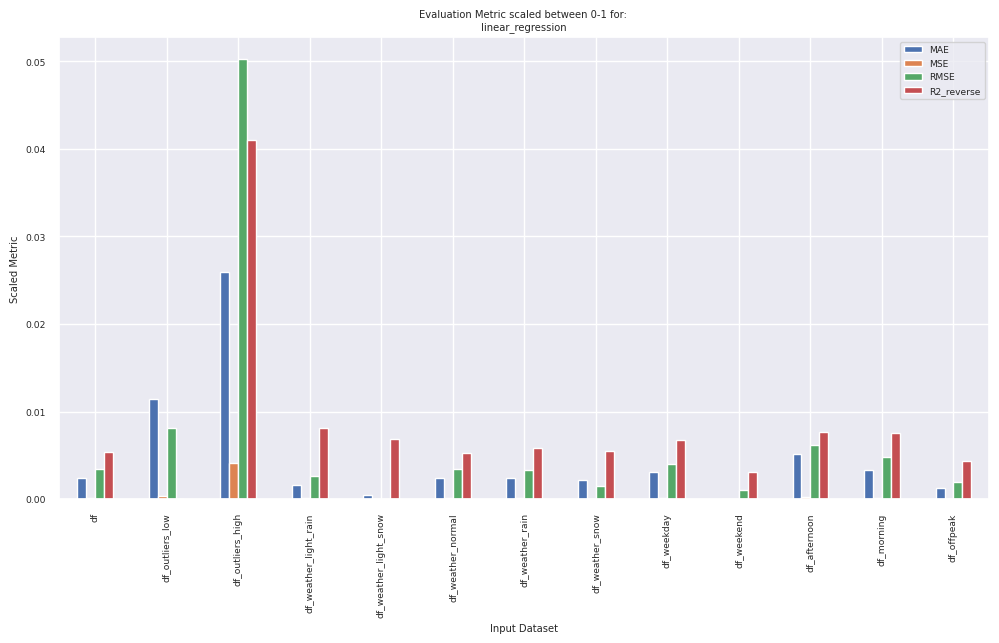

decision_tree
               input_data         MAE            MSE        RMSE        R2
13                     df   13.399999     578.970730   24.061811  0.984601
14        df_outliers_low  172.547021  236528.413964  486.341869  0.573190
15       df_outliers_high   38.381793    5531.409619   74.373447  0.905334
16  df_weather_light_rain   12.435284     368.631874   19.199788  0.984462
17  df_weather_light_snow   11.992597     293.423205   17.129600  0.985973
18      df_weather_normal   13.456349     592.518973   24.341713  0.984529
19        df_weather_rain   13.086348     412.052481   20.299076  0.988234
20        df_weather_snow   13.018110     353.887958   18.811910  0.988372
21             df_weekday   13.798842     649.891798   25.492975  0.980204
22             df_weekend   12.086329     345.377668   18.584339  0.992717
23           df_afternoon   14.902860     536.795135   23.168840  0.984634
24             df_morning   14.523511    1426.259154   37.765846  0.954695
25         

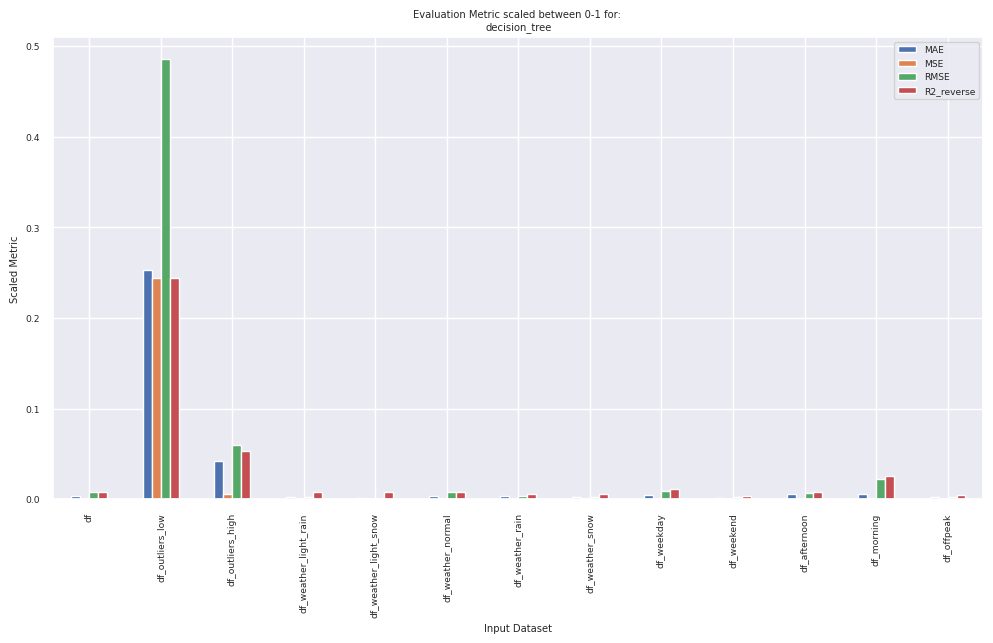

XGBoost
               input_data         MAE            MSE        RMSE        R2
26                     df   14.742560    1273.540377   35.686697  0.966127
27        df_outliers_low  649.644882  968538.538135  984.143556 -0.747706
28       df_outliers_high  144.815792   56738.963103  238.199419  0.028952
29  df_weather_light_rain   13.111280     405.109711   20.127337  0.982925
30  df_weather_light_snow   12.463951     316.786165   17.798488  0.984857
31      df_weather_normal   14.846043    1326.358642   36.419207  0.965368
32        df_weather_rain   13.442452     411.226918   20.278731  0.988258
33        df_weather_snow   13.391664     352.538035   18.775996  0.988416
34             df_weekday   15.227711    1519.861748   38.985404  0.953705
35             df_weekend   13.144616     462.230495   21.499546  0.990253
36           df_afternoon   16.319495     994.940634   31.542680  0.971519
37             df_morning   16.350863    3873.419695   62.236803  0.876962
38             df

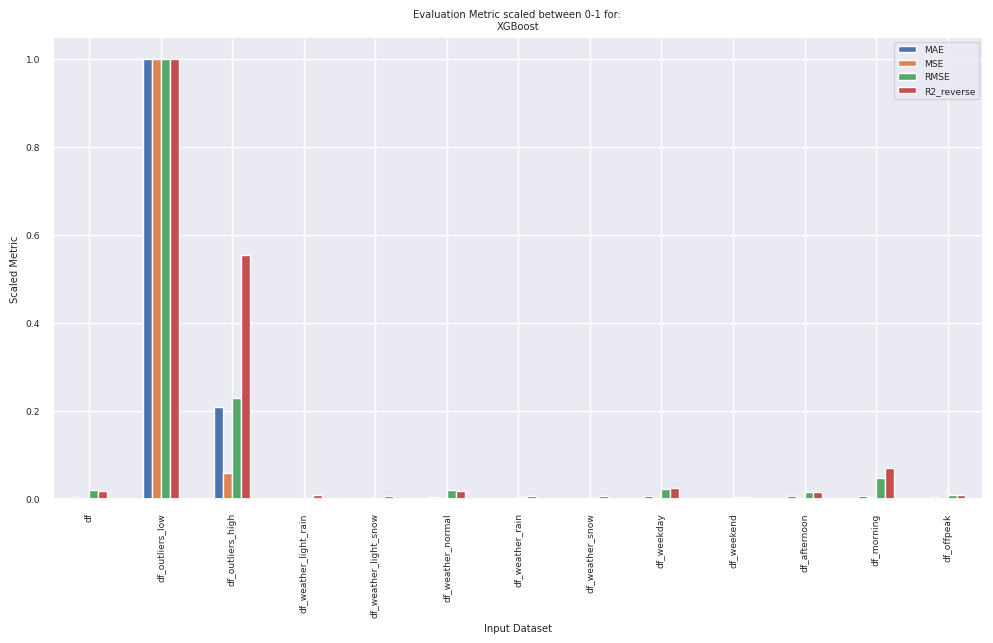

Neural_Net
               input_data        MAE          MSE       RMSE        R2
39                     df  12.613375   415.410877  20.381631  0.988951
40        df_outliers_low  23.636660  1042.118427  32.281859  0.998120
41       df_outliers_high  30.691785  4460.162546  66.784448  0.923667
42  df_weather_light_rain  11.878837   371.619221  19.277428  0.984336
43  df_weather_light_snow  11.574872   295.879237  17.201141  0.985856
44      df_weather_normal  12.651786   419.302002  20.476865  0.989052
45        df_weather_rain  12.781572   415.487258  20.383505  0.988136
46        df_weather_snow  12.489916   345.626177  18.591024  0.988643
47             df_weekday  13.043559   442.599826  21.038057  0.986518
48             df_weekend  11.196474   325.858503  18.051551  0.993129
49           df_afternoon  14.147220   527.305490  22.963133  0.984905
50             df_morning  13.320916   483.666575  21.992421  0.984637
51             df_offpeak  11.916175   360.169697  18.978137  0.99

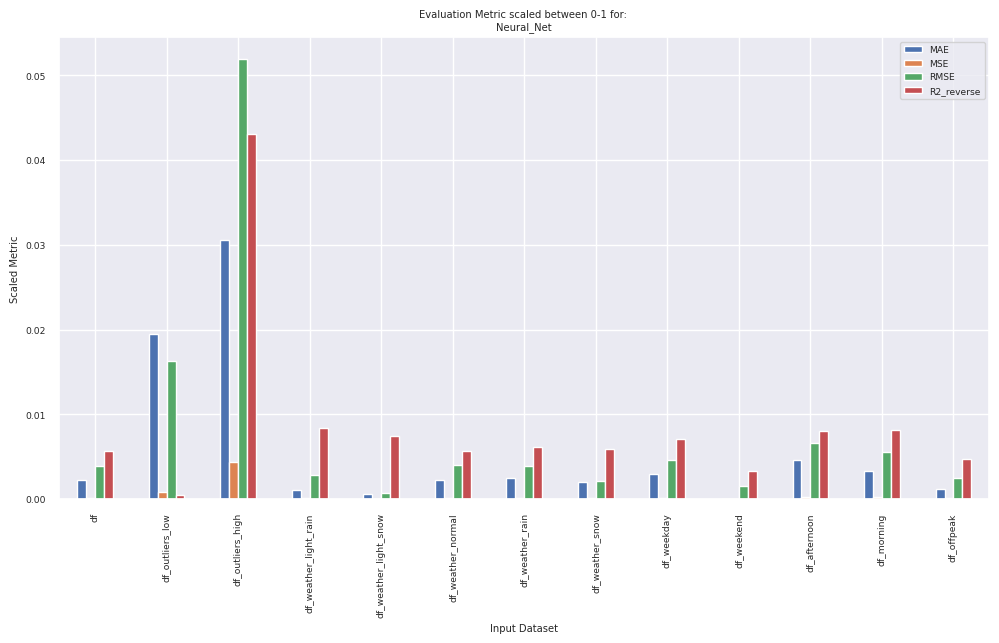

In [35]:
from sklearn.preprocessing import MinMaxScaler

# scale evaluation metrics, for visual inspection
scaler = MinMaxScaler()
result_df['R2_reverse'] = result_df['R2'].apply(lambda x: 1-x)
result_df_scaled = pd.DataFrame(scaler.fit_transform(result_df[['MAE', 'MSE', 'RMSE', 'R2_reverse']]), columns=['MAE', 'MSE', 'RMSE', 'R2_reverse'])
result_df_scaled['input_data'] =result_df['input_data']
result_df_scaled['model'] =result_df['model']

for model in model_names:
  print(model)
  print(pd.DataFrame(result_df[result_df['model'] == model][['input_data', 'MAE', 'MSE', 'RMSE', 'R2']]))

  # plot the scaled metric
  result_df_scaled[result_df_scaled['model'] == model][['input_data', 'MAE', 'MSE', 'RMSE', 'R2_reverse']].set_index('input_data').plot(kind='bar', figsize=(12, 6))
  plt.title('Evaluation Metric scaled between 0-1 for: \n' + model)
  plt.xlabel('Input Dataset')
  plt.ylabel('Scaled Metric')
  plt.show()

